# Roberta Strikes Back !

This notebook demonstates that you can reach decent performances with Roberta, if you process predictions correctly.

The training procedure will not be shared as it would most likely destroy the leaderboard.

# Initialization

### Imports

In [1]:
import os
import re
import ast
import json
import glob
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import wordcloud
import spacy
import warnings

os.environ["TOKENIZERS_PARALLELISM"] = "false"

### Paths

In [2]:
DATA_PATH = "../input/nbme-score-clinical-patient-notes/"
OUT_PATH = "../input/nbme-roberta-large/"
WEIGHTS_FOLDER = "../input/nbme-roberta-large/"

NUM_WORKERS = 2

In [3]:
features = pd.read_csv("../input/nbme-score-clinical-patient-notes/features.csv")
patient_notes = pd.read_csv("../input/nbme-score-clinical-patient-notes/patient_notes.csv")
test = pd.read_csv("../input/nbme-score-clinical-patient-notes/test.csv")
train= pd.read_csv("../input/nbme-score-clinical-patient-notes/train.csv")
sample_submission= pd.read_csv("../input/nbme-score-clinical-patient-notes/sample_submission.csv")

In [4]:
all_notes = []
all_notes_len = []
for notes in patient_notes['pn_history']:
    all_notes.append(notes)
    all_notes_len.append(len(notes))
print("Average length of Patient History - ",np.mean(all_notes_len))
fig = px.histogram(x = all_notes_len,  marginal="violin",nbins = 100)
fig.update_layout(template="plotly_white")
fig.update_xaxes(title = "Length of patient Notes")
fig.show()

Average length of Patient History -  818.1768139325203


In [5]:
all_feat = []
all_feat_len = []
for notes in features['feature_text']:
    all_feat.append(notes)
    all_feat_len.append(len(notes))
print("Average length of Patient History - ",np.mean(all_feat_len))
fig = px.histogram(x = all_feat_len,  marginal="violin",nbins = 200)
fig.update_layout(template="plotly_white")
fig.update_xaxes(title = "Length of Features")
fig.show()

Average length of Patient History -  23.20979020979021


In [6]:
annot_lengths = []
all_annot_words = []
for annot in train["annotation"]:
    for words in annot:
        annot_lengths.append(len(words))
        all_annot_words.append(words)
print("Average length of Annotations - ",np.mean(annot_lengths))
fig = px.histogram(x = annot_lengths,  marginal="violin",nbins = 300)
fig.update_layout(template="plotly_white")
fig.update_xaxes(title = "Length of Annotation")
fig.show()

Average length of Annotations -  1.0


In [7]:
print(f'\033[92mNumber of rows in train data: {train.shape[0]}')
print(f'\033[94mNumber of columns in train data: {train.shape[1]}')
print(f'\033[91mNumber of values in train data: {train.count().sum()}')
print(f'\033[91mNumber missing values in train data: {sum(train.isna().sum())}')
train.head()

Number of rows in train data: 14300
Number of columns in train data: 6
Number of values in train data: 85800
Number missing values in train data: 0


,id,case_num,pn_num,feature_num,annotation,location
0,00016_000,0,16,0,['dad with recent heart attcak'],['696 724']
1,00016_001,0,16,1,"['mom with ""thyroid disease']",['668 693']
2,00016_002,0,16,2,['chest pressure'],['203 217']
3,00016_003,0,16,3,"['intermittent episodes', 'episode']","['70 91', '176 183']"
4,00016_004,0,16,4,['felt as if he were going to pass out'],['222 258']


In [8]:
print(f'\033[92mNumber of rows in test data: {test.shape[0]}')
print(f'\033[94mNumber of columns in test data: {test.shape[1]}')
print(f'\033[91mNumber of values in train data: {test.count().sum()}')
print(f'\033[91mNo of rows with missing values  in test data: {sum(test.isna().sum())}')
test.head()

Number of rows in test data: 5
Number of columns in test data: 4
Number of values in train data: 20
No of rows with missing values  in test data: 0


,id,case_num,pn_num,feature_num
0,00016_000,0,16,0
1,00016_001,0,16,1
2,00016_002,0,16,2
3,00016_003,0,16,3
4,00016_004,0,16,4


In [9]:
print(f'\033[92mNumber of rows in test data: {patient_notes.shape[0]}')
print(f'\033[94mNumber of columns in test data: {patient_notes.shape[1]}')
print(f'\033[91mNumber of values in train data: {patient_notes.count().sum()}')
patient_notes.head()

Number of rows in test data: 42146
Number of columns in test data: 3
Number of values in train data: 126438


,pn_num,case_num,pn_history
0,0,0,"17-year-old male, has come to the student heal..."
1,1,0,17 yo male with recurrent palpitations for the...
2,2,0,Dillon Cleveland is a 17 y.o. male patient wit...
3,3,0,a 17 yo m c/o palpitation started 3 mos ago; \...
4,4,0,17yo male with no pmh here for evaluation of p...


In [10]:
notes_counts = patient_notes.groupby("case_num").count()
fig = px.bar(data_frame =notes_counts, 
             x = notes_counts.index,
             y = 'pn_num' , 
             color = "pn_num",
             color_continuous_scale="Emrld") 
fig.update_layout(title = {
        'text': 'Distribution of patient notes for each case',
        'y':0.95,
        'x':0.48,
        'xanchor': 'center',
        'yanchor': 'top'} ,
                   xaxis = dict(
        tickmode = 'array',
        tickvals = [0, 1,2, 3, 4,5, 6,7,8,9],
        ticktext = ['Case 0', 'Case 1', 'Case 2', 'Case 3', 'Case 4', 'Case 5', 'Case 6', 'Case 7', 'Case 8', 'Case 9']),
                  template = "plotly_white")
fig.show()

In [11]:
print(f'\033[92mNumber of rows in test data: {features.shape[0]}')
print(f'\033[94mNumber of columns in test data: {features.shape[1]}')
print(f'\033[91mNumber of values in train data: {features.count().sum()}')
features.head()

Number of rows in test data: 143
Number of columns in test data: 3
Number of values in train data: 429


,feature_num,case_num,feature_text
0,0,0,Family-history-of-MI-OR-Family-history-of-myoc...
1,1,0,Family-history-of-thyroid-disorder
2,2,0,Chest-pressure
3,3,0,Intermittent-symptoms
4,4,0,Lightheaded


In [12]:
PATIENT_IDX = 74087
patient_df = train[train["pn_num"] == PATIENT_IDX]
patient_df

,id,case_num,pn_num,feature_num,annotation,location
10791,74087_700,7,74087,700,['female'],['27 33']
10792,74087_701,7,74087,701,[],[]
10793,74087_702,7,74087,702,"['only had 2 cycles in the past 5 months', 'he...","['130 168', '182 192', '218 240', '48 73']"
10794,74087_703,7,74087,703,['LMP was 2 months ago'],['97 117']
10795,74087_704,7,74087,704,['has not restarted contraception'],['641 672']
10796,74087_705,7,74087,705,[],[]
10797,74087_706,7,74087,706,['not been able to get pregnant'],['465 494']
10798,74087_707,7,74087,707,['35 yo'],['21 26']
10799,74087_708,7,74087,708,['6 months'],['87 95']


In [13]:
print(f"\033[94mPatient Notes - ")
print(f'\033[94m',patient_notes[patient_notes["pn_num"] == PATIENT_IDX]["pn_history"].iloc[0])
print("------------")
print(f'\033[92mAnnotaions:')
for i in range(len(patient_df)):
    print(f'\033[92m',patient_df["annotation"].iloc[i])

Patient Notes - 
 Angela Tompkins is a 35 yo female presenting w/ abnormal menstraul cycles for the past 6 months. LMP was 2 months ago and she has only had 2 cycles in the past 5 months. She has had heavy flow during recent cycles and will last about 7 days. They used to only last 3-4 days and had regular intervals. She has hardly had any pain w/ her cycles. She used to take oral contraceptives but stopped eleven years ago to try and get pregnant. She has been unsuccessful and not been able to get pregnant despite having sexual intercourse with her boyfriend and trying "for years". She denies trying to become pregnant now and in the recent past. She has not restarted contraception since trying to become pregnant. She had her first pap smear 6 months ago that did not have any abnormal findings. She has regular obgyn follow up. Her aunt has breast cancer and her grandmother had cervical cancer. Family has not done any genetic testing.
------------
Annotaions:
 ['female']
 []
 ['only had

In [14]:
train["location"] = train["location"].apply(eval)
train['annotation'] = train['annotation'].apply(eval)
train["annot_count"] = 0
for i in range(len(train)):
    train["annot_count"][i] = len(train["annotation"][i])
total_annot = 0
for idx in train["annot_count"].value_counts().sort_index().index:
    total_annot += train["annot_count"].value_counts().sort_index()[idx] * idx
print(f'\033[92mTotal number of Annotations is train data  : ' , total_annot)
print(f'\033[94mAnnotation count per row: ')
print(f'\033[94m',train["annot_count"].value_counts().sort_index())

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Total number of Annotations is train data  :  12234
Annotation count per row: 
 0    4399
1    8181
2    1296
3     287
4      99
5      27
6       9
7       1
8       1
Name: annot_count, dtype: int64


In [15]:
patient_df = train[train["pn_num"] == PATIENT_IDX]
location  = patient_df["location"]
annotation = patient_df["annotation"]
start_pos = []
end_pos = []
for i in location:
    for j in i:
        start_pos.append(j.split()[0])
        end_pos.append(j.split()[1])
        
ents = []
for i in range(len(start_pos)):
    ents.append({
        'start': int(start_pos[i]), 
        'end' : int(end_pos[i]),
        "label" : "Annotation"
    })
doc = {
    'text' : patient_notes[patient_notes["pn_num"] == PATIENT_IDX]["pn_history"].iloc[0],
    "ents" : ents
}
colors = {"Annotation" :"linear-gradient(90deg, #aa9cfc, #fc9ce7)" } 
options = {"colors": colors}
spacy.displacy.render(doc, style="ent", options = options , manual=True, jupyter=True);

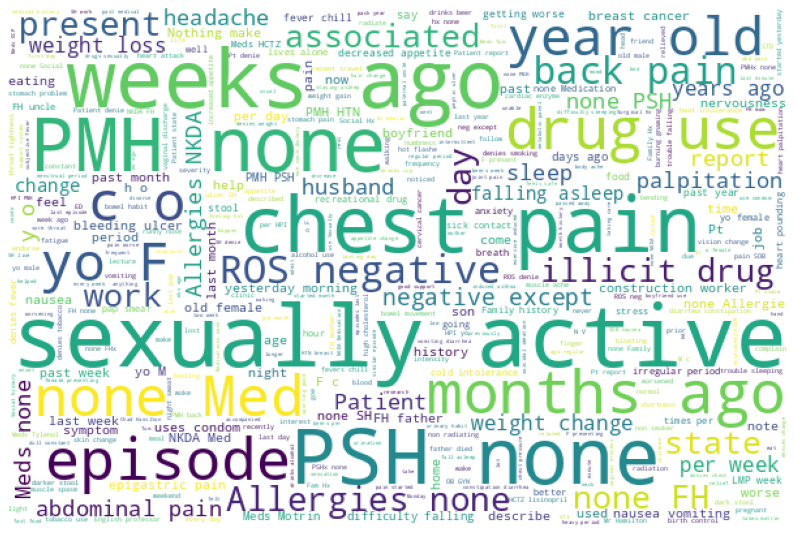

In [16]:
wordcloud_notes = wordcloud.WordCloud(stopwords=wordcloud.STOPWORDS, max_font_size=120, max_words=5000,
                      width = 600, height = 400,
                      background_color='white').generate(" ".join(all_notes))
fig, ax = plt.subplots(figsize=(14,10))
ax.imshow(wordcloud_notes, interpolation='bilinear')
ax.set_axis_off()
plt.imshow(wordcloud_notes);

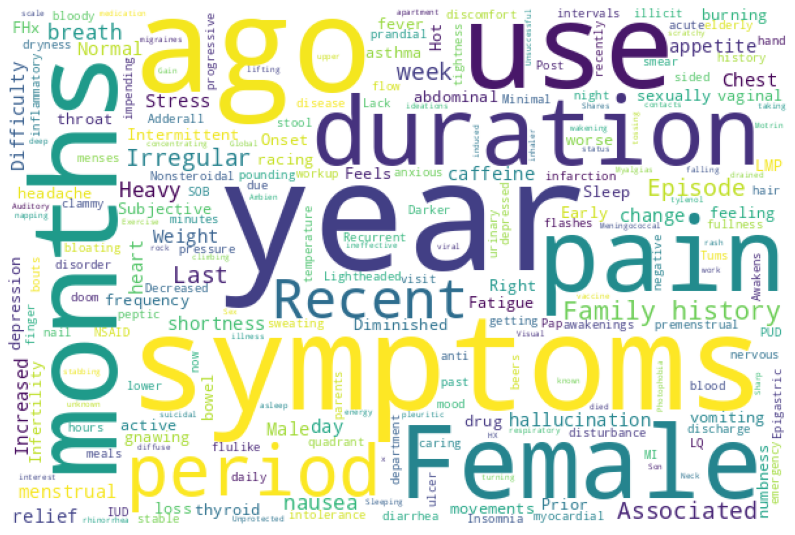

In [17]:
wordcloud_feat = wordcloud.WordCloud(stopwords=wordcloud.STOPWORDS, max_font_size=120, max_words=5000,
                      width = 600, height = 400,
                      background_color='white').generate(" ".join(all_feat))
fig, ax = plt.subplots(figsize=(14,10))
ax.imshow(wordcloud_feat, interpolation='bilinear')
ax.set_axis_off()
plt.imshow(wordcloud_feat);

# Data

## Preparation

In [18]:
def process_feature_text(text):
    text = re.sub('I-year', '1-year', text)
    text = re.sub('-OR-', " or ", text)
    text = re.sub('-', ' ', text)
    return text


def clean_spaces(txt):
    txt = re.sub('\n', ' ', txt)
    txt = re.sub('\t', ' ', txt)
    txt = re.sub('\r', ' ', txt)
#     txt = re.sub(r'\s+', ' ', txt)
    return txt


def load_and_prepare_test(root=""):
    patient_notes = pd.read_csv(root + "patient_notes.csv")
    features = pd.read_csv(root + "features.csv")
    df = pd.read_csv(root + "test.csv")

    df = df.merge(features, how="left", on=["case_num", "feature_num"])
    df = df.merge(patient_notes, how="left", on=['case_num', 'pn_num'])

    df['pn_history'] = df['pn_history'].apply(lambda x: x.strip())
    df['feature_text'] = df['feature_text'].apply(process_feature_text)

    df['feature_text'] = df['feature_text'].apply(clean_spaces)
    df['clean_text'] = df['pn_history'].apply(clean_spaces)

    df['target'] = ""
    return df

### Processing

In [19]:
import itertools


def token_pred_to_char_pred(token_pred, offsets):
    char_pred = np.zeros((np.max(offsets), token_pred.shape[1]))
    for i in range(len(token_pred)):
        s, e = int(offsets[i][0]), int(offsets[i][1])  # start, end
        char_pred[s:e] = token_pred[i]

        if token_pred.shape[1] == 3:  # following characters cannot be tagged as start
            s += 1
            char_pred[s: e, 1], char_pred[s: e, 2] = (
                np.max(char_pred[s: e, 1:], 1),
                np.min(char_pred[s: e, 1:], 1),
            )

    return char_pred


def labels_to_sub(labels):
    all_spans = []
    for label in labels:
        indices = np.where(label > 0)[0]
        indices_grouped = [
            list(g) for _, g in itertools.groupby(
                indices, key=lambda n, c=itertools.count(): n - next(c)
            )
        ]

        spans = [f"{min(r)} {max(r) + 1}" for r in indices_grouped]
        all_spans.append(";".join(spans))
    return all_spans


def char_target_to_span(char_target):
    spans = []
    start, end = 0, 0
    for i in range(len(char_target)):
        if char_target[i] == 1 and char_target[i - 1] == 0:
            if end:
                spans.append([start, end])
            start = i
            end = i + 1
        elif char_target[i] == 1:
            end = i + 1
        else:
            if end:
                spans.append([start, end])
            start, end = 0, 0
    return spans

## Tokenization

In [20]:
import numpy as np
from transformers import AutoTokenizer


def get_tokenizer(name, precompute=False, df=None, folder=None):
    if folder is None:
        tokenizer = AutoTokenizer.from_pretrained(name)
    else:
        tokenizer = AutoTokenizer.from_pretrained(folder)

    tokenizer.name = name
    tokenizer.special_tokens = {
        "sep": tokenizer.sep_token_id,
        "cls": tokenizer.cls_token_id,
        "pad": tokenizer.pad_token_id,
    }

    if precompute:
        tokenizer.precomputed = precompute_tokens(df, tokenizer)
    else:
        tokenizer.precomputed = None

    return tokenizer


def precompute_tokens(df, tokenizer):
    feature_texts = df["feature_text"].unique()

    ids = {}
    offsets = {}

    for feature_text in feature_texts:
        encoding = tokenizer(
            feature_text,
            return_token_type_ids=True,
            return_offsets_mapping=True,
            return_attention_mask=False,
            add_special_tokens=False,
        )
        ids[feature_text] = encoding["input_ids"]
        offsets[feature_text] = encoding["offset_mapping"]

    texts = df["clean_text"].unique()

    for text in texts:
        encoding = tokenizer(
            text,
            return_token_type_ids=True,
            return_offsets_mapping=True,
            return_attention_mask=False,
            add_special_tokens=False,
        )
        ids[text] = encoding["input_ids"]
        offsets[text] = encoding["offset_mapping"]

    return {"ids": ids, "offsets": offsets}


def encodings_from_precomputed(feature_text, text, precomputed, tokenizer, max_len=300):
    tokens = tokenizer.special_tokens

    # Input ids
    if "roberta" in tokenizer.name:
        qa_sep = [tokens["sep"], tokens["sep"]]
    else:
        qa_sep = [tokens["sep"]]

    input_ids = [tokens["cls"]] + precomputed["ids"][feature_text] + qa_sep
    n_question_tokens = len(input_ids)

    input_ids += precomputed["ids"][text]
    input_ids = input_ids[: max_len - 1] + [tokens["sep"]]

    # Token type ids
    if "roberta" not in tokenizer.name:
        token_type_ids = np.ones(len(input_ids))
        token_type_ids[:n_question_tokens] = 0
        token_type_ids = token_type_ids.tolist()
    else:
        token_type_ids = [0] * len(input_ids)

    # Offsets
    offsets = [(0, 0)] * n_question_tokens + precomputed["offsets"][text]
    offsets = offsets[: max_len - 1] + [(0, 0)]

    # Padding
    padding_length = max_len - len(input_ids)
    if padding_length > 0:
        input_ids = input_ids + ([tokens["pad"]] * padding_length)
        token_type_ids = token_type_ids + ([0] * padding_length)
        offsets = offsets + ([(0, 0)] * padding_length)

    encoding = {
        "input_ids": input_ids,
        "token_type_ids": token_type_ids,
        "offset_mapping": offsets,
    }

    return encoding


## Dataset

In [21]:
import torch
import numpy as np
from torch.utils.data import Dataset


class PatientNoteDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.df = df
        self.max_len = max_len
        self.tokenizer = tokenizer

        self.texts = df['clean_text'].values
        self.feature_text = df['feature_text'].values
        self.char_targets = df['target'].values.tolist()

    def __getitem__(self, idx):
        text = self.texts[idx]
        feature_text = self.feature_text[idx]
        char_target = self.char_targets[idx]

        # Tokenize
        if self.tokenizer.precomputed is None:
            encoding = self.tokenizer(
                feature_text,
                text,
                return_token_type_ids=True,
                return_offsets_mapping=True,
                return_attention_mask=False,
                truncation="only_second",
                max_length=self.max_len,
                padding='max_length',
            )
            raise NotImplementedError("fix issues with question offsets")
        else:
            encoding = encodings_from_precomputed(
                feature_text,
                text,
                self.tokenizer.precomputed,
                self.tokenizer,
                max_len=self.max_len
            )

        return {
            "ids": torch.tensor(encoding["input_ids"], dtype=torch.long),
            "token_type_ids": torch.tensor(encoding["token_type_ids"], dtype=torch.long),
            "target": torch.tensor([0], dtype=torch.float),
            "offsets": np.array(encoding["offset_mapping"]),
            "text": text,
        }

    def __len__(self):
        return len(self.texts)


### Plot predictions

In [22]:
import spacy
import numpy as np

def plot_annotation(df, pn_num):
    options = {"colors": {}}

    df_text = df[df["pn_num"] == pn_num].reset_index(drop=True)

    text = df_text["pn_history"][0]
    ents = []

    for spans, feature_text, feature_num in df_text[["span", "feature_text", "feature_num"]].values:
        for s in spans:
            ents.append({"start": int(s[0]), "end": int(s[1]), "label": feature_text})

        options["colors"][feature_text] =  f"rgb{tuple(np.random.randint(100, 255, size=3))}"

    doc = {"text": text, "ents": sorted(ents, key=lambda i: i["start"])}

    spacy.displacy.render(doc, style="ent", options=options, manual=True, jupyter=True)

# Model

In [23]:
import torch
import transformers
import torch.nn as nn
from transformers import AutoConfig, AutoModel


class NERTransformer(nn.Module):
    def __init__(
        self,
        model,
        num_classes=1,
        config_file=None,
        pretrained=True,
    ):
        super().__init__()
        self.name = model
        self.pad_idx = 1 if "roberta" in self.name else 0

        transformers.logging.set_verbosity_error()

        if config_file is None:
            config = AutoConfig.from_pretrained(model, output_hidden_states=True)
        else:
            config = torch.load(config_file)

        if pretrained:
            self.transformer = AutoModel.from_pretrained(model, config=config)
        else:
            self.transformer = AutoModel.from_config(config)

        self.nb_features = config.hidden_size

#         self.cnn = nn.Identity()
        self.logits = nn.Linear(self.nb_features, num_classes)

    def forward(self, tokens, token_type_ids):
        """
        Usual torch forward function

        Arguments:
            tokens {torch tensor} -- Sentence tokens
            token_type_ids {torch tensor} -- Sentence tokens ids
        """
        hidden_states = self.transformer(
            tokens,
            attention_mask=(tokens != self.pad_idx).long(),
            token_type_ids=token_type_ids,
        )[-1]

        features = hidden_states[-1]

        logits = self.logits(features)

        return logits

# Inference

## Loads weights

In [24]:
import torch

def load_model_weights(model, filename, verbose=1, cp_folder="", strict=True):
    """
    Loads the weights of a PyTorch model. The exception handles cpu/gpu incompatibilities.

    Args:
        model (torch model): Model to load the weights to.
        filename (str): Name of the checkpoint.
        verbose (int, optional): Whether to display infos. Defaults to 1.
        cp_folder (str, optional): Folder to load from. Defaults to "".
        strict (bool, optional): Whether to allow missing/additional keys. Defaults to False.

    Returns:
        torch model: Model with loaded weights.
    """
    if verbose:
        print(f"\n -> Loading weights from {os.path.join(cp_folder,filename)}\n")

    try:
        model.load_state_dict(
            torch.load(os.path.join(cp_folder, filename), map_location="cpu"),
            strict=strict,
        )
    except RuntimeError:
        model.encoder.fc = torch.nn.Linear(model.nb_ft, 1)
        model.load_state_dict(
            torch.load(os.path.join(cp_folder, filename), map_location="cpu"),
            strict=strict,
        )

    return model

## Predict

In [25]:
import torch
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm


def predict(model, dataset, data_config, activation="softmax"):
    """
    Usual predict torch function
    """
    model.eval()

    loader = DataLoader(
        dataset,
        batch_size=data_config['val_bs'],
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=True,
    )

    preds = []
    with torch.no_grad():
        for data in tqdm(loader):
            ids, token_type_ids = data["ids"], data["token_type_ids"]

            y_pred = model(ids.cuda(), token_type_ids.cuda())

            if activation == "sigmoid":
                y_pred = y_pred.sigmoid()
            elif activation == "softmax":
                y_pred = y_pred.softmax(-1)

            preds += [
                token_pred_to_char_pred(y, offsets) for y, offsets
                in zip(y_pred.detach().cpu().numpy(), data["offsets"].numpy())
            ]

    return preds


## Inference

In [26]:
def inference_test(df, exp_folder, config, cfg_folder=None):
    preds = []

    if cfg_folder is not None:
        model_config_file = cfg_folder + config.name.split('/')[-1] + "/config.pth"
        tokenizer_folder = cfg_folder + config.name.split('/')[-1] + "/tokenizers/"
    else:
        model_config_file, tokenizer_folder = None, None

    tokenizer = get_tokenizer(
        config.name, precompute=config.precompute_tokens, df=df, folder=tokenizer_folder
    )

    dataset = PatientNoteDataset(
        df,
        tokenizer,
        max_len=config.max_len,
    )

    model = NERTransformer(
        config.name,
        num_classes=config.num_classes,
        config_file=model_config_file,
        pretrained=False
    ).cuda()
    model.zero_grad()

    weights = sorted(glob.glob(exp_folder + "*.pt"))
    for weight in weights:
        model = load_model_weights(model, weight)

        pred = predict(
            model,
            dataset,
            data_config=config.data_config,
            activation=config.loss_config["activation"]
        )
        preds.append(pred)

    return preds

# Main

## Config

In [27]:
class Config:
    # Architecture
    name = "roberta-large"
    num_classes = 1

    # Texts
    max_len = 310
    precompute_tokens = True

    # Training    
    loss_config = {
        "activation": "sigmoid",
    }

    data_config = {
        "val_bs": 16 if "large" in name else 32,
        "pad_token": 1 if "roberta" in name else 0,
    }

    verbose = 1

## Data

In [28]:
df_test = load_and_prepare_test(root=DATA_PATH)
df_test.head()

,id,case_num,pn_num,feature_num,feature_text,pn_history,clean_text,target
0,00016_000,0,16,0,Family history of MI or Family history of myoc...,HPI: 17yo M presents with palpitations. Patien...,HPI: 17yo M presents with palpitations. Patien...,
1,00016_001,0,16,1,Family history of thyroid disorder,HPI: 17yo M presents with palpitations. Patien...,HPI: 17yo M presents with palpitations. Patien...,
2,00016_002,0,16,2,Chest pressure,HPI: 17yo M presents with palpitations. Patien...,HPI: 17yo M presents with palpitations. Patien...,
3,00016_003,0,16,3,Intermittent symptoms,HPI: 17yo M presents with palpitations. Patien...,HPI: 17yo M presents with palpitations. Patien...,
4,00016_004,0,16,4,Lightheaded,HPI: 17yo M presents with palpitations. Patien...,HPI: 17yo M presents with palpitations. Patien...,


## Inference

In [29]:
preds = inference_test(
    df_test,
    WEIGHTS_FOLDER,
    Config,
    cfg_folder=OUT_PATH
)[0]


 -> Loading weights from ../input/nbme-roberta-large/roberta-large_0.pt



  0%|          | 0/1 [00:00<?, ?it/s]

In [30]:
df_test['preds'] = preds
df_test['preds'] = df_test.apply(lambda x: x['preds'][:len(x['clean_text'])], 1)

df_test['preds'] = df_test['preds'].apply(lambda x: (x > 0.5).flatten())

## Plot predictions

In [31]:
try:
    df_test['span'] = df_test['preds'].apply(char_target_to_span)
    plot_annotation(df_test, df_test['pn_num'][0])
except:
    pass

Unlike for deberta, spaces are not included in the offsets, we need to add them manually otherwise this will hurt performances.

## Post-processing

In [32]:
def post_process_spaces(target, text):
    target = np.copy(target)

    if len(text) > len(target):
        padding = np.zeros(len(text) - len(target))
        target = np.concatenate([target, padding])
    else:
        target = target[:len(text)]

    if text[0] == " ":
        target[0] = 0
    if text[-1] == " ":
        target[-1] = 0

    for i in range(1, len(text) - 1):
        if text[i] == " ":
            if target[i] and not target[i - 1]:  # space before
                target[i] = 0

            if target[i] and not target[i + 1]:  # space after
                target[i] = 0

            if target[i - 1] and target[i + 1]:
                target[i] = 1

    return target

In [33]:
df_test['preds_pp'] = df_test.apply(lambda x: post_process_spaces(x['preds'], x['clean_text']), 1)

In [34]:
try:
    df_test['span'] = df_test['preds_pp'].apply(char_target_to_span)
    plot_annotation(df_test, df_test['pn_num'][0])
except:
    pass

## Submission

In [35]:
df_test['location'] = labels_to_sub(df_test['preds_pp'].values)

sub = pd.read_csv(DATA_PATH + 'sample_submission.csv')

sub = sub[['id']].merge(df_test[['id', "location"]], how="left", on="id")

sub.to_csv('submission.csv', index=False)

sub.head()

,id,location
0,00016_000,696 724
1,00016_001,668 693
2,00016_002,203 217
3,00016_003,70 91
4,00016_004,222 258
